In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Basic convolutional neural network
import keras_tuner as kt
from keras_tuner import BayesianOptimization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import os, numpy as np, time
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

In [3]:
def hms(start, end):
    seconds = end-start
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return h,m,s

In [4]:
def create_model(hp):
    """
    Compiles a model integrated with pretrained layers
    
    """
    learning_rate = hp.Choice('learning_rate', values = [0.000001, 0.00001, 0.0001], default = 0.000001)
    dropout_rate = hp.Float('dropout', 0.2, 0.8, step=0.1)
    neurons = hp.Choice('neurons', values = [256, 512, 1024, 2048], default = 256)
    dense_layers = hp.Int('dense_layers', 0, 2, default = 0)
    pooling = hp.Choice("global_pooling", ["flatten", "avg"], default = 'flatten')
        
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = EfficientNetB0(include_top=False,
                     weights='imagenet', 
                     input_shape=(224, 224, 3))
    
    # Layers in the convolutional base are switched from trainable to non-trainable
    for layer in conv_base.layers:
        layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    
    # Choose top model pooling layer.
    if pooling == "avg":
        top_model = GlobalAveragePooling2D()(top_model)
        for dl in range(dense_layers):
            top_model = Dense(neurons, activation='relu')(top_model)
            top_model = Dropout(dropout_rate)(top_model)
    else:
        top_model = Flatten(name="flatten")(top_model)
        for dl in range(dense_layers):
            top_model = Dense(neurons, activation='relu')(top_model)
            top_model = Dropout(dropout_rate)(top_model)
    
    # Add final softmax layer for predictions
    output_layer = Dense(5, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                                 loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
train_data_dir = 'cropped_resized_imgs/train'
test_data_dir = 'cropped_resized_imgs/test'
class_subset = sorted(os.listdir(train_data_dir))

img_size = 224
BATCH_SIZE = 128
totalstart = time.time()
modelName = 'EfficientNetB0'
filename = 'EfficientNetB0_HP_Tuning_Results.txt'

# create image generators with data augmentation
train_generator = ImageDataGenerator(
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15,       # 15% of the data will be used for validation at end of each epoch
    preprocessing_function=preprocess_input # preprocessing
)

traingen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='training',
                                                shuffle=True,
                                                seed=55)

validgen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='validation',
                                                shuffle=True,
                                                seed=55)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=55)
# set model run values
n_epochs = 50
max_trial_epochs = 40
max_trials = 35
n_steps = traingen.samples / BATCH_SIZE
n_val_steps = validgen.samples / BATCH_SIZE

tuner = BayesianOptimization(create_model,
                objective = 'val_accuracy',
                max_trials = max_trials,
                directory = 'hp_models',
                project_name = modelName,
                overwrite = True,
                seed=55)

# Early Stopping
tuner_early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

tuner.search(traingen,
            batch_size=BATCH_SIZE,
            epochs=max_trial_epochs,
            validation_data=validgen,
            steps_per_epoch=n_steps,
            validation_steps=n_val_steps,
            callbacks=[tuner_early_stop],
            workers=16,
            verbose=1)

# print and save tuner results
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

print(tuner.results_summary(num_trials=max_trials))

with open(filename, 'w') as f:
    best_model[0].summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('Best hyperparameters: {}\n\nBest Model Summary\n'.format(best_hp.values))
    best_model[0].summary(print_fn=lambda x: f.write(x + '\n'))

# ************************************************************************************************************
# train full model with hyperparameters

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='weights/{}.hp.weights.hdf5'.format(modelName),
                                  save_best_only=True,
                                  verbose=1)

# load and train model from hyperparameters
bestTunedModel = tuner.hypermodel.build(best_hp)
history = bestTunedModel.fit(traingen,
                    batch_size=BATCH_SIZE,
                    epochs=n_epochs,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    callbacks=[tl_checkpoint_1],
                    workers=16,
                    verbose=1)

# load model weights
bestTunedModel.load_weights('weights/{}.hp.weights.hdf5'.format(modelName)) # initialize the best trained weights
# get labels
labels = traingen.class_indices
labels = dict((v,k) for k,v in labels.items())

# Generate predictions
testgen.reset()
predstart = time.time()
preds = bestTunedModel.predict(testgen)
pred_classes = np.argmax(preds, axis=1)
true_classes = testgen.classes
acc = accuracy_score(true_classes, pred_classes)
predend = time.time()
avgPredictionTime = (predend - predstart)/1200

print("Best {} Model Accuracy: {:.2f}%".format(modelName, acc * 100))

# save history object to disk
with open('modelrun_history/{}.hp.history'.format(modelName), 'wb') as histfile:
    pickle.dump(history.history, histfile)

# save model accuracy to file
with open(filename, 'a') as f:
    f.write("{} Model Accuracy: {:.2f}%\n".format(modelName, acc * 100))
    f.write("Average prediction time per image: {} seconds\n".format(avgPredictionTime))

# total modeling time
totalEnd = time.time()
totalT=hms(totalstart, totalEnd)
print("Average prediction time per image: {} seconds\n".format(avgPredictionTime))
print('Total runtime is {:.0f} hours, {:.0f} minutes, {:.1f} seconds'.format(totalT[0],totalT[1],totalT[2]))
with open(filename, 'a') as f:
    f.write('Total runtime is {:.0f} hours, {:.0f} minutes, {:.1f} seconds'.format(totalT[0],totalT[1],totalT[2]))

Trial 35 Complete [00h 08m 17s]
val_accuracy: 0.8638888597488403

Best val_accuracy So Far: 0.8888888955116272
Total elapsed time: 03h 24m 24s
INFO:tensorflow:Oracle triggered exit
{'learning_rate': 0.0001, 'dropout': 0.4000000000000001, 'neurons': 2048, 'dense_layers': 1, 'global_pooling': 'avg'}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]            

Epoch 1/50
31/31 [==============================] - 19s 377ms/step - loss: 0.8870 - accuracy: 0.7203 - val_loss: 0.7204 - val_accuracy: 0.7583

Epoch 00001: val_loss improved from inf to 0.72044, saving model to weights\EfficientNetB0.hp.weights.hdf5


C:\Users\jquan\miniconda3\envs\ds785\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
31/31 [==============================] - 12s 301ms/step - loss: 0.3479 - accuracy: 0.9051 - val_loss: 0.5267 - val_accuracy: 0.8028

Epoch 00002: val_loss improved from 0.72044 to 0.52670, saving model to weights\EfficientNetB0.hp.weights.hdf5
Epoch 3/50
31/31 [==============================] - 12s 300ms/step - loss: 0.2461 - accuracy: 0.9336 - val_loss: 0.4725 - val_accuracy: 0.8306

Epoch 00003: val_loss improved from 0.52670 to 0.47245, saving model to weights\EfficientNetB0.hp.weights.hdf5
Epoch 4/50
31/31 [==============================] - 12s 304ms/step - loss: 0.1994 - accuracy: 0.9417 - val_loss: 0.4251 - val_accuracy: 0.8403

Epoch 00004: val_loss improved from 0.47245 to 0.42514, saving model to weights\EfficientNetB0.hp.weights.hdf5
Epoch 5/50
31/31 [==============================] - 12s 304ms/step - loss: 0.1701 - accuracy: 0.9525 - val_loss: 0.4402 - val_accuracy: 0.8333

Epoch 00005: val_loss did not improve from 0.42514
Epoch 6/50
31/31 [======================


Epoch 00041: val_loss did not improve from 0.31990
Epoch 42/50
31/31 [==============================] - 13s 299ms/step - loss: 0.0477 - accuracy: 0.9831 - val_loss: 0.3723 - val_accuracy: 0.8667

Epoch 00042: val_loss did not improve from 0.31990
Epoch 43/50
31/31 [==============================] - 12s 301ms/step - loss: 0.0460 - accuracy: 0.9860 - val_loss: 0.4170 - val_accuracy: 0.8569

Epoch 00043: val_loss did not improve from 0.31990
Epoch 44/50
31/31 [==============================] - 12s 305ms/step - loss: 0.0432 - accuracy: 0.9877 - val_loss: 0.3468 - val_accuracy: 0.8778

Epoch 00044: val_loss did not improve from 0.31990
Epoch 45/50
31/31 [==============================] - 12s 301ms/step - loss: 0.0543 - accuracy: 0.9824 - val_loss: 0.3924 - val_accuracy: 0.8764

Epoch 00045: val_loss did not improve from 0.31990
Epoch 46/50
31/31 [==============================] - 12s 300ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.4371 - val_accuracy: 0.8611

Epoch 00046: val_lo

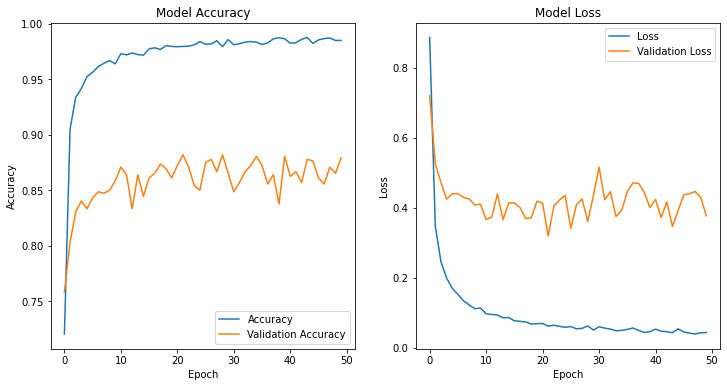

In [6]:
# plot training/validation accuracy and loss
plt.figure(figsize=(12, 6)) # figsize(width, height) in inches, dpi=100
# plot accuracy
plt.subplot(1, 2, 1) # (rows, cols, index)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.subplot(1, 2, 2) # (rows, cols, index)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])